# Autoencoders and Generative Adversarial Networks - Part 2/3
### XX Seminar on Software for Nuclear, Subnuclear and Applied Physics, 4-9 June 2023, Hotel Porto Conte, Maristella SS, IT

Contacts: 
 * email: Lucio.Anderlini [at] fi.infn.it
 * GitHub: [github.com/landerlini](https://github.com/landerlini)

## Shaping the latent space

In the previous part, we have defined the concept of autoencoder and we have discussed possible application to Transfer Learning and Anomaly Detection, based on the reconstruction error as test statistic. We have also noticed that the anomalies tend to accumulate in regions less populated of the latent space, which suggests to further investigate the latent space.

In this notebook we will try to play with a Convolutional Autoencoder to shape the latent space.


## Setting the scene

Let's copy-paste from the previous lecture the steps of data pre-processing and the `rough_inspection` function.


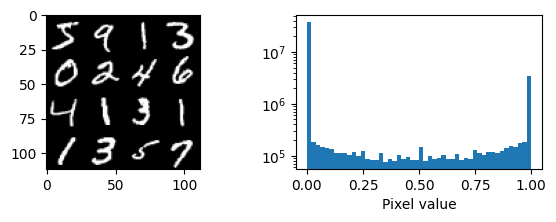

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf

def rough_inspection(dataset, n_fig=4):
    figure = np.concatenate([np.reshape(dataset[n_fig*i:n_fig*(i+1)], (n_fig*28, 28)) for i in range(n_fig)], axis=1)

    plt.figure(figsize=(7,2))
    plt.subplot(1, 2, 1)
    plt.imshow(figure, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(dataset.flatten(), bins=50)
    plt.yscale('log')
    plt.xlabel("Pixel value")
    plt.show()
    
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_idx = sum([np.arange(len(y_train))[y_train == i].tolist()[:4] for i in range(10)], [])
test_idx = sum([np.arange(len(y_test))[y_test == i].tolist()[:4] for i in range(10)], [])

Lx_train = x_train[train_idx]
Lx_test = x_test[test_idx]
Ly_train = y_train[train_idx]
Ly_test = y_test[test_idx]

px_train = (x_train / x_train.max())
px_test = (x_test / x_train.max()) 
pLx_train = (Lx_train / x_train.max())
pLx_test = (Lx_test / x_train.max()) 

py_train = np.stack([Ly_train == i for i in range(10)], axis=1)
py_test = np.stack([Ly_test == i for i in range(10)], axis=1)

rough_inspection(px_train)

# A Convolutional Autoencoder

Let's drop the Dense layers and let's define a Convolutional Autoencoder.

This time we will define two networks, one for the Encoder and one for the decoder and we will use them separately.

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam

###############################
## Definition of the ENCODER 

encoder = Sequential([
    Reshape((28, 28, 1)),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    Conv2D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    Conv2D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(2, activation='linear')
])

encoder.build(input_shape=(None, 28, 28))
display(encoder.summary())

###############################
## Definition of the DECODER

decoder = Sequential([
    Dense(32, activation='tanh'),
    Dense(28//4*28//4, activation='tanh'),
    Reshape((28//4, 28//4, 1)),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(32, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(16, kernel_size=(2, 2), padding='same', activation='relu'),
    UpSampling2D(size=(2 ,2)),
    Conv2DTranspose(8, kernel_size=(2, 2), padding='same', activation='relu'),
    Conv2DTranspose(1, kernel_size=(2, 2), padding='same', activation='sigmoid'),
    Reshape((28,28)),
])
decoder.build(input_shape=encoder.output_shape)

display(decoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        2320      
                                                        

2023-05-30 12:41:04.492654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 12:41:04.510828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 12:41:04.512577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-30 12:41:04.514560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

None

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                96        
                                                                 
 dense_4 (Dense)             (None, 49)                1617      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 1)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         160       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 7, 7, 32)         4128      
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)      

None

## Let's make the training loop explicit

Instead of using the `fit` function provided by Keras, let's have a look to the inner logic of the training loop.
While not particularly useful for this application, in itself, it is worth starting with a simple case that then we will make more complex.

  0%|          | 0/50 [00:00<?, ?it/s]2023-05-30 12:41:06.224205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-05-30 12:41:07.178860: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|██████████| 50/50 [03:36<00:00,  4.33s/it]


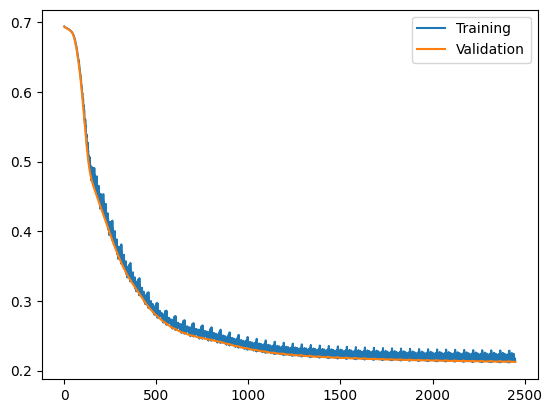

In [4]:
## Define the optimizer
ae_optimizer = Adam(1e-4)

## Define a function to update the weights on a chunk of the training dataset
def ae_train_step(train_data):
    ## Retrieve the trainable weights of the two networks (encoder and decoder)
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights

    ## Combines them into the whole list of variables
    ae_vars = enc_vars + dec_vars

    ## Create a GradientTape to record the gradient of the loss with respect to the 
    ## traniable weights.
    with tf.GradientTape() as tp: 
        ## Then we describe the operations part of the model: encoding first
        encoded = encoder(train_data)
        ## deconding then
        decoded = decoder(encoded)

        ## And finally, we compute the loss as a BinaryCrossentropy.
        loss = BinaryCrossentropy()(train_data, decoded) 

        
    ## Once the gradients are recorded on tape, we can compute them
    ae_grads = tp.gradient(loss, ae_vars)
    
    ## and use them to update the weights
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

    return loss

## We also define a test step which replicates the operations performed during the 
## training, but without updating the weights nor computing the gradients.
def ae_test_step(test_data):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    loss = BinaryCrossentropy()(test_data, decoded)

    return loss


## Then we start the training loop, keeping track of the losses for each update.
losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 50)[:-1]]
val_chunk = tf.constant(px_test[:1000])


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(50):
    for chunk in chunks:
        losses.append(ae_train_step(chunk))
        val_losses.append(ae_test_step(val_chunk))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


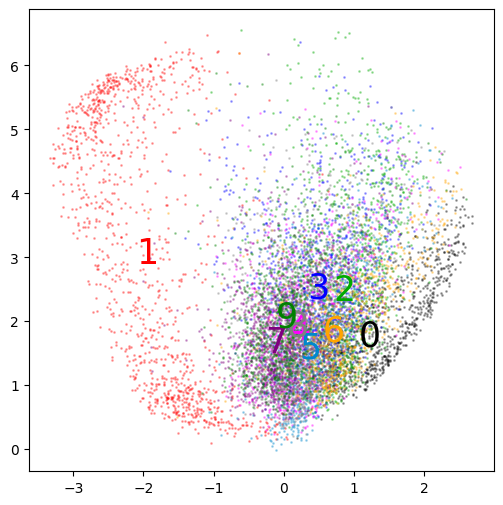

In [5]:
encoded_test = encoder.predict(px_test)


u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()

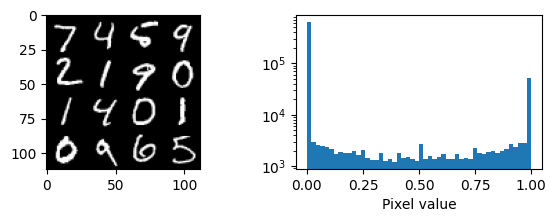

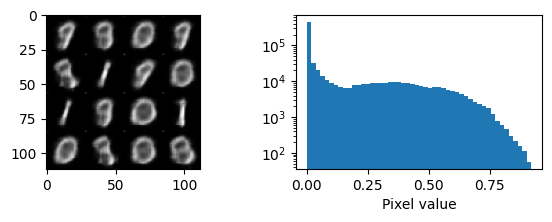

In [6]:
reconstructed = decoder(encoder(val_chunk)).numpy()
rough_inspection(val_chunk.numpy())
rough_inspection(reconstructed)

100%|██████████| 30/30 [01:48<00:00,  3.62s/it]


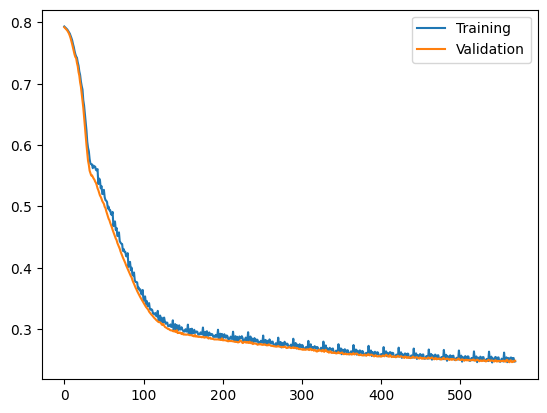

In [7]:
ae_optimizer = Adam(1e-3)

def ae_train_step(train_data, labels):
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights

    ae_vars = enc_vars + dec_vars

    with tf.GradientTape() as tp:
        encoded = encoder(train_data)
        decoded = decoder(encoded)

        pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
        labeled_loss = tf.reduce_mean(
            tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
        )
        
        loss = BinaryCrossentropy()(train_data, decoded) + 0.1*labeled_loss

    ae_grads = tp.gradient(loss, ae_vars)
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))

    return loss

def ae_test_step(test_data, labels):
    encoded = encoder(test_data)
    decoded = decoder(encoded)

    pins = tf.stack([tf.math.cos(2*np.pi*labels/10), tf.math.sin(2*np.pi*labels/10)], axis=1)
    labeled_loss = tf.reduce_mean(
        tf.where(tf.math.is_finite(labels), tf.linalg.norm(encoded - pins, axis=1), 0.)
    )
        
    loss = BinaryCrossentropy()(test_data, decoded) + 0.1*labeled_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 20)[:-1]]
label_chunks = [tf.constant(c, dtype=tf.float32) for c in np.split(y_train, 20)[:-1]]

val_chunk = tf.constant(px_test[:1000])
val_label = tf.constant(y_test[:1000], dtype=tf.float32)


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)

from tqdm import trange
for epoch in trange(30):
    for chunk, label_chunk in zip(chunks, label_chunks):
        losses.append(ae_train_step(chunk, label_chunk))
        val_losses.append(ae_test_step(val_chunk, val_label))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


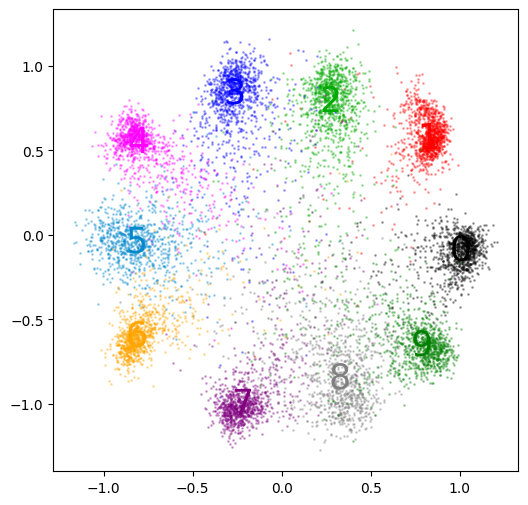

In [8]:
encoded_test = encoder.predict(px_test)

u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.show()

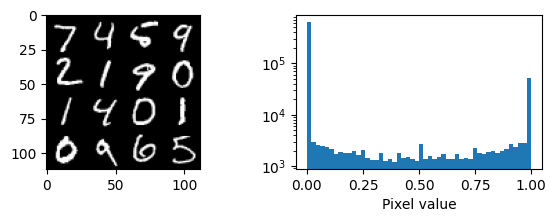

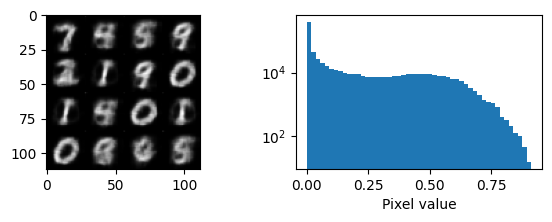

In [9]:
reconstructed = decoder(encoder(val_chunk)).numpy()
rough_inspection(val_chunk.numpy())
rough_inspection(reconstructed)

In [18]:
classifier = Sequential()
classifier.add(Dense(64, activation='tanh', kernel_regularizer=L2(1e-2))
classifier.add(Dense(64, activation='tanh', kernel_regularizer=L2(1e-2))
classifier.add(Dense(64, activation='tanh', kernel_regularizer=L2(1e-2))
classifier.add(Dense(1, activation='sigmoid'))

classifier.build(input_shape=(None, 2))
display(classifier)

100%|██████████| 50/50 [04:54<00:00,  5.90s/it]


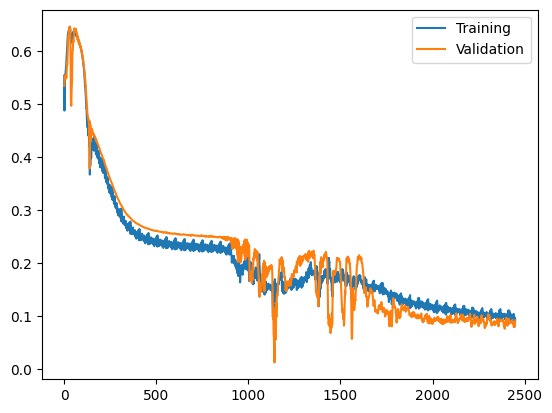

In [19]:
ae_optimizer = Adam(1e-4)
adv_optimizer = Adam(3e-2)

def ae_train_step(train_data):
    enc_vars = encoder.trainable_weights
    dec_vars = decoder.trainable_weights
    adv_vars = classifier.trainable_weights

    ae_vars = enc_vars + dec_vars

    with tf.GradientTape() as tp, tf.GradientTape() as adv_tp:
        encoded = encoder(train_data)
        decoded = decoder(encoded)
        classif = classifier(encoded)
        
        adv_loss = (
            BinaryCrossentropy(label_smoothing=0.1)(tf.ones_like(classif), classif) + 
            BinaryCrossentropy(label_smoothing=0.1)(tf.zeros_like(classif), classifier(tf.random.normal(tf.shape(encoded))))
        )
        
        loss = BinaryCrossentropy()(train_data, decoded) - 0.1* adv_loss

    ae_grads = tp.gradient(loss, ae_vars)
    adv_grads = adv_tp.gradient(adv_loss, adv_vars)
    
    ae_optimizer.apply_gradients(zip(ae_grads, ae_vars))
    adv_optimizer.apply_gradients(zip(adv_grads, adv_vars))

    return loss

def ae_test_step(test_data):
    encoded = encoder(test_data)
    decoded = decoder(encoded)
    classif = classifier(encoded)

    adv_loss = (
            BinaryCrossentropy()(tf.ones_like(classif), classif) + 
            BinaryCrossentropy()(tf.zeros_like(classif), classifier(tf.random.normal(tf.shape(encoded), 0, 0.2)))
        )
        
    loss = BinaryCrossentropy()(test_data, decoded) - 0.1*adv_loss

    return loss


losses = []
val_losses = []
chunks = [tf.constant(c) for c in np.split(px_train, 50)[:-1]]

val_chunk = tf.constant(px_test[:1000])


## Reset the weights
from tensorflow.keras.models import clone_model
decoder = clone_model(decoder)
encoder = clone_model(encoder)
classifier = clone_model(classifier)

from tqdm import trange
for epoch in trange(50):
    for chunk in chunks:
        losses.append(ae_train_step(chunk))
        val_losses.append(ae_test_step(val_chunk))

plt.plot(losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.legend()
plt.show()

In [28]:
encoded_test = encoder.predict(px_test)
if False:
    u, v = encoded_test.T
    plt.figure(figsize=(6,6))
    colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
    for digit, color in zip(range(10), colors):
        plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
        u_mean = np.quantile(u[y_test == digit], 0.5)
        v_mean = np.quantile(v[y_test == digit], 0.5)
        plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

    #plt.plot(np.random.normal(0.0, 0.2, 1000), np.random.normal(0.0, 0.2, 1000), 'ko', markersize=1)

    plt.show()

313/313 [==============================] - 0s 1ms/step


In [29]:
!conda run -p /envs/root pip install -q emnist
import emnist
letters, _ = emnist.extract_training_samples('letters')
digits, _ = emnist.extract_training_samples('digits')

letters = letters[:30000]/255


938/938 [==============================] - 1s 1ms/step


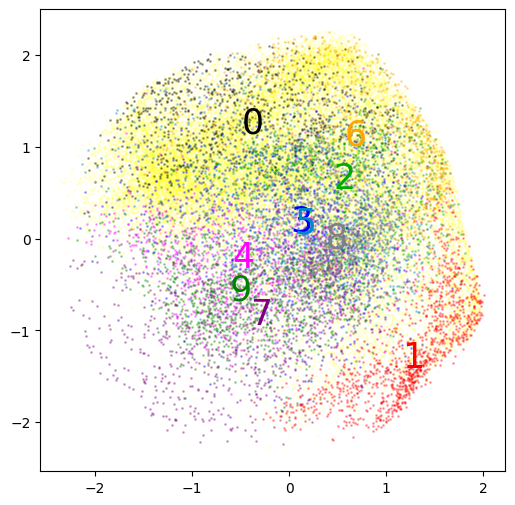

In [30]:
encoded_test = encoder.predict(px_test)
encoded_letters = encoder.predict(letters)

u, v = encoded_test.T
plt.figure(figsize=(6,6))
colors = ['black', 'red', '#0a0', 'blue', 'magenta', '#08c', 'orange', 'purple', 'gray', 'green']
for digit, color in zip(range(10), colors):
    plt.plot(u[y_test == digit], v[y_test == digit], 'o', color=color, markersize=1, alpha=0.3)
    u_mean = np.quantile(u[y_test == digit], 0.5)
    v_mean = np.quantile(v[y_test == digit], 0.5)
    plt.text(u_mean, v_mean, f"{digit}", fontsize=25, alpha=1, color=color, ha='center', va='center')

plt.plot(encoded_letters[:,0], encoded_letters[:,1], 'o', markersize=1, alpha=0.1, color='yellow', zorder=-100)
    
plt.show()

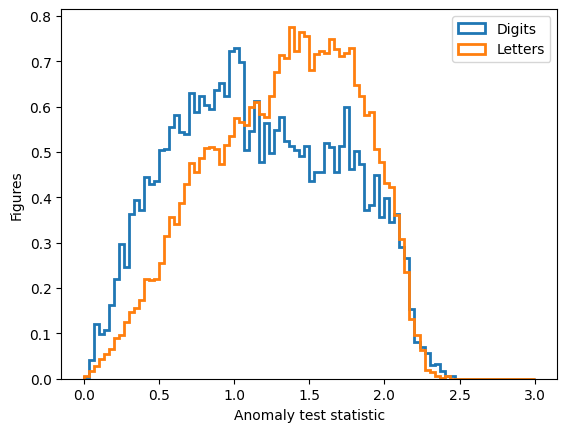

In [35]:
t_test = np.linalg.norm(encoded_test, axis=1)
t_letters = np.linalg.norm(encoded_letters, axis=1)

bins = np.linspace(0, 3, 91)
plt.hist(t_test, bins=bins, label="Digits", density=True, histtype='step', linewidth=2)
plt.hist(t_letters, bins=bins, label="Letters", density=True, histtype='step', linewidth=2)
plt.xlabel("Anomaly test statistic")
plt.ylabel("Figures")
plt.legend()
plt.show()